# Проект: классификация

Александр Журавлев DST-120
***

# Итерация №3.   
На данной итерации мы сделаем следующее:
- заново найдем выбросы в непрерывных числовых признаках
- подберем метод sklearn для поиска выбросов
- проведем отбор признаков
- настроим гиперпараметры моделей
- оценим модели, построив кривые обучения 
     
**Примечание.** На прошлой итерации мы уже искали выбросы методом Тьюки. Однако данный поиск проходил на всем датасете, что, с одной стороны, помогло нам проанализировать непрерывные числовые признаки на заморачиваясь разбиением на тренировочную и тестовую выборки, но, с другой стороны, привело к тому, что модель "увидела" тестовую выборку. Косвенно это подтверждается тем (с моей точки зрения), что важность выбросов (см. диаграммы деревьев решений), найденных нами методом Тьюки, была выше, чем важность выбросов, найденых методом библиотеки sklearn (там обучение шло только на тренировочной выборке!), хотя логично предположить, что методы библиотеки sklearn реализованы более качественно. Другими словами, на прошлой итерации мы получили переобученную модель в контексте отмеченных выбросов.          
Учитывая вышесказанное, мы будем определять пороги выбросов только (!) на тренировочной выборке, а затем, учитывая эти пороги, отметим выбросы на тренировочной и тестовой выборках. Для разнообразия и тренировки навыков используем метод Z-отклонений.
    
**Еще примечание:** при перезапуске ноутбука значения некоторых метрик у некоторых моделей могут менятся +/- на 0.01   
Вероятно, это происходит по причине того, что алгоритмы sklearn по очистке данных носят стохастический характер.
***

# Задача
→ Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

Вам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача** для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### Данные о клиентах банка:

- **age** (возраст);
- **job** (сфера занятости);
- **marital** (семейное положение);
- **education** (уровень образования);
- **default** (имеется ли просроченный кредит);
- **housing** (имеется ли кредит на жильё);
- **loan** (имеется ли кредит на личные нужды);
- **balance** (баланс).

### Данные, связанные с последним контактом:

- **contact** (тип контакта с клиентом);
- **month** (месяц, в котором был последний контакт);
- **day** (день, в который был последний контакт);
- **duration** (продолжительность контакта в секундах).

### Прочие признаки:

- **campaign** (количество контактов с этим клиентом в течение текущей кампании);
- **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- **previous** (количество контактов до текущей кампании)
- **poutcome** (результат прошлой маркетинговой кампании).

### Целевой признак:

- **deposit**.

***

## 0. Подготовительный этап

### Импортируем необходимые библиотеки

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.model_selection import cross_val_score, cross_val_predict # для кросс-валидации

# для поиска выбросов
from sklearn.covariance import EllipticEnvelope 
from  sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# тесты для отбора признаков
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, chi2, mutual_info_classif

# для оптимизации модели
import optuna

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# не отображаем предупреждения
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# импортируем функции из my_functions.py
# для определения мультиколлинеарности
from my_functions import get_top_abs_correlations
# для OneHotEncoding тренировочной и тестовой выборок
from my_functions import encode_cat_features 
# для поиска выбросов методом Z-отклонений
from my_functions import outliers_z_score
# для построения кривой обучения
from my_functions import plot_learning_curve
# для визуализации зависимости метрик от порога вероятности
from my_functions import dependence_metrics_threshold    
# для построения PR-кривой модели
from my_functions import plot_pr_curve

### Определим константы и загрузим данные

In [2]:
# для воспроизводимости результатов
random_state = 42 

In [3]:
# загрузим обновленные данные
df = pd.read_csv('data/df_EDA.csv')

In [4]:
# создаём и фиксируем объект кросс-валидатора KFold
kf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

***

## 1. Подготовка данных

### 1.1. Удалим признаки с найденными выбросами на предыдущей итерации 

In [5]:
df.drop(['balance_outliers', 'duration_outliers', 'campaign_outliers'], axis=1, inplace=True)

### 1.2. Удалим пропуски в данных

In [6]:
# список признаков с неявными пропусками
nan_category_features = ['job', 'education', 'contact', 'poutcome']

# превращаем неявные пропуски в явные
for feature in nan_category_features:
    df[feature] = df[feature].apply(
        lambda x: np.nan if x == 'unknown' else x
    )

In [7]:
# удалим признак poutcome
df_dropna = df.drop('poutcome', axis=1)

# удалим строки с пропусками
df_dropna = df_dropna.dropna()

print(f'Размер данных до удаления пропусков {df.shape}')
print(f'Размер данных после удаления пропусков {df_dropna.shape}')
reduction_percentage = 100 - df_dropna.shape[0] / df.shape[0] * 100
print(f'Датасет уменьшился на {round(reduction_percentage)} %')

Размер данных до удаления пропусков (11162, 46)
Размер данных после удаления пропусков (8376, 45)
Датасет уменьшился на 25 %


### 1.3. Выделяем целевую переменную и предикторы, разделяем выборку на обучающую и тестовую.

In [8]:
# X - матрица наблюдений, y - столбец правильных ответов
X = df_dropna.drop('deposit', axis=1)
y = df_dropna['deposit']

На этой итерации разделение на тренировочную и тестовую выборки проведем в соотношении 70/30.

In [9]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    test_size=0.3, # размер тестовой выборки
    random_state=random_state, # число отвечающее за генерацию случайных чисел
    stratify=y # стратификация, т.к. таргент несбалансирован
)

# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (5863, 44)
Test shape: (2513, 44)


## 2. Повторно обработаем непрерывные числовые признаки

### 2.1. Признак **age**

Попробуем найти выбросы в тренировочной выборке.

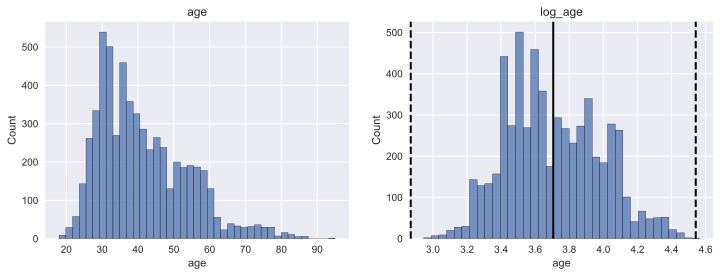

In [10]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='age', ax=axes[0]).set_title('age');
# Логарифмируем
log_age = np.log(X_train['age']+1)
sns.histplot(data=log_age, ax=axes[1]).set_title('log_age');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_age.mean(), color='k', lw=2)
axes[1].axvline(log_age.mean()+ 3 *log_age.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_age.mean()- 3 *log_age.std(),
                color='k', ls='--', lw=2);

Справа, вроде, есть выбросы, но это неточно.

In [11]:
# работаем с тренировочной выборкой

# создадим признак age_outliers с метками выбросов
X_train['age_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'age', log_scale=True)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'age_outliers'] = 1 

lower bound = 2.8696071223525017
upper bound = 4.541948223470817
total outliers in *age*: 1


Нашли целый 1 выброс. Теперь пометим выбросы на тестовой выборке, используя границы выбросов, полученные на тренировочной выборке.

In [12]:
# помечаем выбросы на тестовой выборке

# создадим признак age_outliers с метками выбросов
X_test['age_outliers'] = X_test['age'].apply(
    lambda x: 1 if ((np.log(x+1)) < lower_bound) or ((np.log(x+1)) > upper_bound) else 0 
)

In [13]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.age_outliers.value_counts()

0    2513
Name: age_outliers, dtype: int64

Выбросов на тестовой выборке нет.

### 2.2. Признак **balance**

Попробуем найти выбросы в тренировочной выборке.

In [14]:
# найдем наименьшее значение признака на тренировочной выборке
X_train.balance.min()

-3058.0

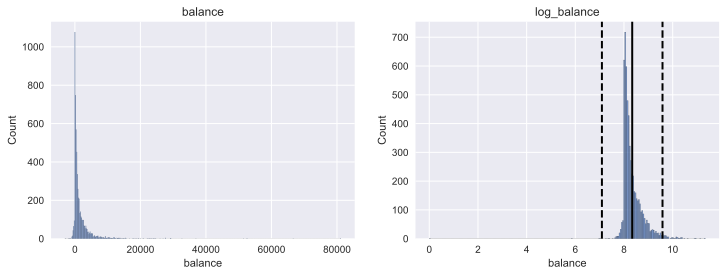

In [15]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='balance', ax=axes[0]).set_title('balance');
# Логарифмируем
log_balance = np.log(X_train['balance']+3059) # учитываем нименьшее значение признака
sns.histplot(data=log_balance, ax=axes[1]).set_title('log_balance');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_balance.mean(), color='k', lw=2)
axes[1].axvline(log_balance.mean()+ 3 *log_balance.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_balance.mean()- 3 *log_balance.std(),
                color='k', ls='--', lw=2);

Есть выбросы.

In [16]:
# работаем с тренировочной выборкой

# создадим признак balance_outliers с метками выбросов
X_train['balance_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'balance', log_scale=True, y=3059)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'balance_outliers'] = 1 

lower bound = 7.092906422524694
upper bound = 9.582496216397162
total outliers in *balance*: 104


In [17]:
# помечаем выбросы на тестовой выборке

# создадим признак balance_outliers с метками выбросов
X_test['balance_outliers'] = X_test['balance'].apply(
    lambda x: 1 if ((np.log(x+3059)) < lower_bound) or ((np.log(x+3059)) > upper_bound) else 0 
)

In [18]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.balance_outliers.value_counts()

0    2470
1      43
Name: balance_outliers, dtype: int64

На тестовой выборке 43 выброса.

### 2.3. Признак **duration**

Попробуем найти выбросы в тренировочной выборке.

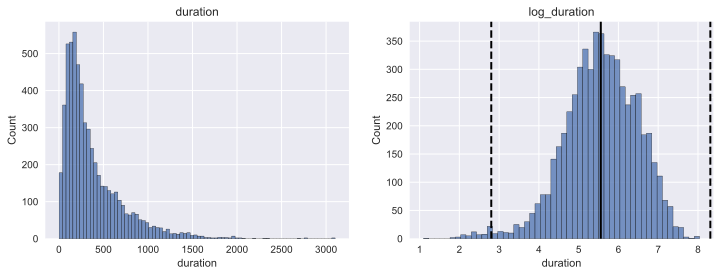

In [19]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='duration', ax=axes[0]).set_title('duration');
# Логарифмируем
log_duration = np.log(X_train['duration']+1)
sns.histplot(data=log_duration, ax=axes[1]).set_title('log_duration');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_duration.mean(), color='k', lw=2)
axes[1].axvline(log_duration.mean()+ 3 *log_duration.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_duration.mean()- 3 *log_duration.std(),
                color='k', ls='--', lw=2);

Есть выбросы.

In [20]:
# работаем с тренировочной выборкой

# создадим признак duration_outliers с метками выбросов
X_train['duration_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'duration', log_scale=True)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'duration_outliers'] = 1 

lower bound = 2.8025445653981365
upper bound = 8.310949499576987
total outliers in *duration*: 60


In [21]:
# помечаем выбросы на тестовой выборке

# создадим признак duration_outliers с метками выбросов
X_test['duration_outliers'] = X_test['duration'].apply(
    lambda x: 1 if ((np.log(x+1)) < lower_bound) or ((np.log(x+1)) > upper_bound) else 0 
)

In [22]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.duration_outliers.value_counts()

0    2485
1      28
Name: duration_outliers, dtype: int64

### 2.4. Признак **pdays**

In [23]:
# найдем минимальное значение признака
X_train.pdays.min()

-1

Попробуем найти выбросы в тренировочной выборке.

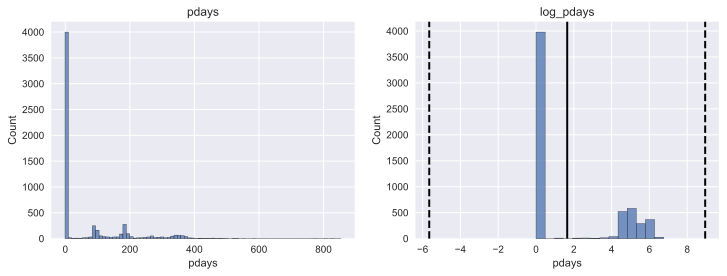

In [24]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='pdays', ax=axes[0]).set_title('pdays');
# Логарифмируем
log_pdays = np.log(X_train['pdays']+2) # учитывая минимальное значение признака
sns.histplot(data=log_pdays, ax=axes[1]).set_title('log_pdays');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_pdays.mean(), color='k', lw=2)
axes[1].axvline(log_pdays.mean()+ 3 *log_pdays.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_pdays.mean()- 3 *log_pdays.std(),
                color='k', ls='--', lw=2);

Выбросов нет.

### 2.5. Признак **campaign**

Попробуем найти выбросы в тренировочной выборке.

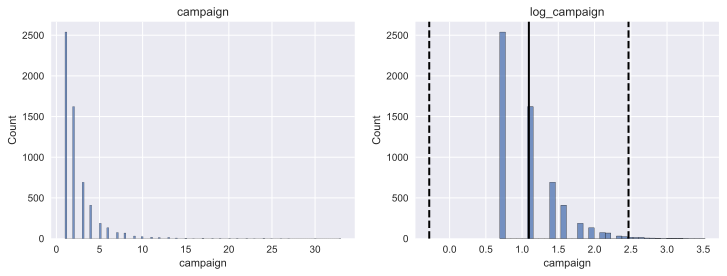

In [25]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='campaign', ax=axes[0]).set_title('campaign');
# Логарифмируем
log_campaign = np.log(X_train['campaign']+1) 
sns.histplot(data=log_campaign, ax=axes[1]).set_title('log_campaign');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_campaign.mean(), color='k', lw=2)
axes[1].axvline(log_campaign.mean()+ 3 *log_campaign.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_campaign.mean()- 3 *log_campaign.std(),
                color='k', ls='--', lw=2);

С одной стороны, значений признака менее 40 и гистограмма напоминает больше распределение категориального признака. С другой стороны, справа выбросы есть. Будем экспериментировать.

In [26]:
# работаем с тренировочной выборкой

# создадим признак campaign_outliers с метками выбросов
X_train['campaign_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'campaign', log_scale=True)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'campaign_outliers'] = 1 

lower bound = -0.2811001485636948
upper bound = 2.4685631659510046
total outliers in *campaign*: 80


In [27]:
# помечаем выбросы на тестовой выборке

# создадим признак campaign_outliers с метками выбросов
X_test['campaign_outliers'] = X_test['campaign'].apply(
    lambda x: 1 if ((np.log(x+1)) < lower_bound) or ((np.log(x+1)) > upper_bound) else 0 
)

In [28]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.campaign_outliers.value_counts()

0    2461
1      52
Name: campaign_outliers, dtype: int64

### 2.5. Признак **AgeBalanceRatio**

In [29]:
# найдем наименьшее значение признака на тренировочной выборке
X_train.AgeBalanceRatio.min()

-78.41025641025641

Попробуем найти выбросы в тренировочной выборке.

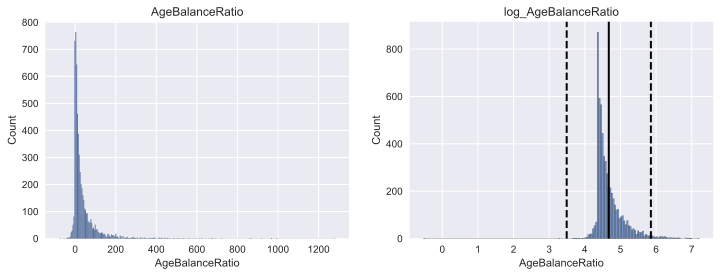

In [30]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='AgeBalanceRatio', ax=axes[0]).set_title('AgeBalanceRatio');
# Логарифмируем
log_AgeBalanceRatio = np.log(X_train['AgeBalanceRatio']+79) # учитываем минимальное значение признака
sns.histplot(data=log_AgeBalanceRatio, ax=axes[1]).set_title('log_AgeBalanceRatio');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_AgeBalanceRatio.mean(), color='k', lw=2)
axes[1].axvline(log_AgeBalanceRatio.mean()+ 3 *log_AgeBalanceRatio.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_AgeBalanceRatio.mean()- 3 *log_AgeBalanceRatio.std(),
                color='k', ls='--', lw=2);

Выбросы есть.

In [31]:
# работаем с тренировочной выборкой

# создадим признак AgeBalanceRatio_outliers с метками выбросов
X_train['AgeBalanceRatio_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'AgeBalanceRatio', log_scale=True, y=79)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'AgeBalanceRatio_outliers'] = 1 

lower bound = 3.4913626825101827
upper bound = 5.854213048810008
total outliers in *AgeBalanceRatio*: 116


In [32]:
# помечаем выбросы на тестовой выборке

# создадим признак AgeBalanceRatio_outliers с метками выбросов
X_test['AgeBalanceRatio_outliers'] = X_test['AgeBalanceRatio'].apply(
    lambda x: 1 if ((np.log(x+79)) < lower_bound) or ((np.log(x+79)) > upper_bound) else 0 
)

In [33]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.AgeBalanceRatio_outliers.value_counts()

0    2462
1      51
Name: AgeBalanceRatio_outliers, dtype: int64

### 2.6. Признак **DurationCampaignRatio**

Попробуем найти выбросы в тренировочной выборке.

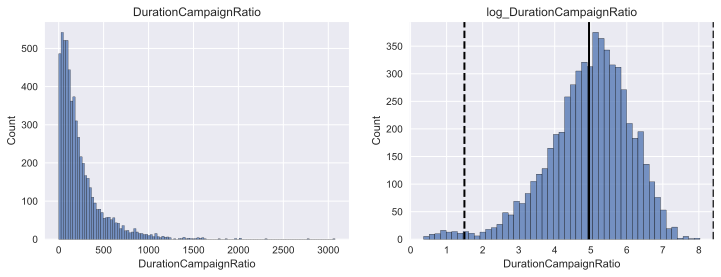

In [34]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='DurationCampaignRatio', ax=axes[0]).set_title('DurationCampaignRatio');
# Логарифмируем
log_DurationCampaignRatio = np.log(X_train['DurationCampaignRatio']+1) 
sns.histplot(data=log_DurationCampaignRatio, ax=axes[1]).set_title('log_DurationCampaignRatio');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_DurationCampaignRatio.mean(), color='k', lw=2)
axes[1].axvline(log_DurationCampaignRatio.mean()+ 3 *log_DurationCampaignRatio.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_DurationCampaignRatio.mean()- 3 *log_DurationCampaignRatio.std(),
                color='k', ls='--', lw=2);

Выбросы есть.

In [35]:
# работаем с тренировочной выборкой

# создадим признак DurationCampaignRatio_outliers с метками выбросов
X_train['DurationCampaignRatio_outliers'] = 0
# находим выбросы и получаем границы выбросов
outliers, lower_bound, upper_bound = outliers_z_score(X_train, 'DurationCampaignRatio', log_scale=True)
# пометим выбросы значением 1
X_train.loc[outliers.index, 'DurationCampaignRatio_outliers'] = 1 

lower bound = 1.494364755854925
upper bound = 8.410520690340785
total outliers in *DurationCampaignRatio*: 82


In [36]:
# помечаем выбросы на тестовой выборке

# создадим признак DurationCampaignRatio_outliers с метками выбросов
X_test['DurationCampaignRatio_outliers'] = X_test['DurationCampaignRatio'].apply(
    lambda x: 1 if ((np.log(x+1)) < lower_bound) or ((np.log(x+1)) > upper_bound) else 0 
)

In [37]:
# посмотрим, сколько выбросов на тестовой выборке
X_test.DurationCampaignRatio_outliers.value_counts()

0    2480
1      33
Name: DurationCampaignRatio_outliers, dtype: int64

### 2.7. Признак **PdaysCampaignRatio**

In [38]:
# найдем наименьшее значение признака на тренировочной выборке
X_train.PdaysCampaignRatio.min()

-1.0

Попробуем найти выбросы в тренировочной выборке.

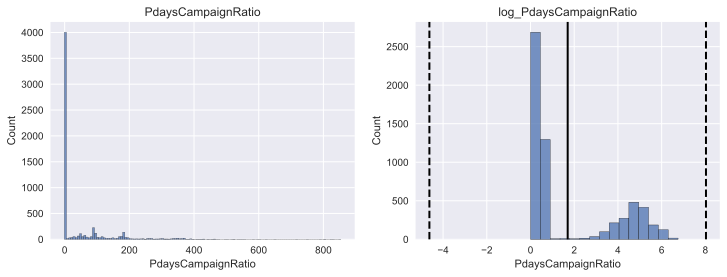

In [39]:
# визуализируем распределение признака и его логарифмированого варианта
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму
sns.histplot(data=X_train, x='PdaysCampaignRatio', ax=axes[0]).set_title('PdaysCampaignRatio');
# Логарифмируем
log_PdaysCampaignRatio = np.log(X_train['PdaysCampaignRatio']+2) # учитываем минимальное значение признака
sns.histplot(data=log_PdaysCampaignRatio, ax=axes[1]).set_title('log_PdaysCampaignRatio');

# Добавляем вертикальные линии для среднего и 3-х стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_PdaysCampaignRatio.mean(), color='k', lw=2)
axes[1].axvline(log_PdaysCampaignRatio.mean()+ 3 *log_PdaysCampaignRatio.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_PdaysCampaignRatio.mean()- 3 *log_PdaysCampaignRatio.std(),
                color='k', ls='--', lw=2);

Выбросов нет.

**Промежуточный вывод по разделу:** в результате поиска выбросов методом Z-отклонений не удалось увеличить *f1-score*, однако удалось увеличить *precision* и *recall* на некоторых моделях.

## 3. Кодируем признаки

In [40]:
# обновим бинарные признаки, заменяя 'yes' и 'no' на 1 и 0

# список с бинарными признаками
binary_features = ['housing', 'loan',  'default']

# обновляем признаки на обеих выборках
for feature in binary_features:
    X_train[feature] = X_train[feature].apply(
        lambda x: 1 if x == 'yes' else 0
    )
    X_test[feature] = X_test[feature].apply(
        lambda x: 1 if x == 'yes' else 0
    )

In [41]:
# выделяем признаки для OneHotEncoding
columns_to_change = [
    'job', 'marital', 'education', 'age_group', 'balance_group',  'day',
    'month', 'year_season', 'pdays_group', 'contact'
]

In [42]:
# кодируем тренировочную и тестовую выборки по отдельности, обучаясь на тренировочной
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

## 4. Поиск выбросов методами библиотеки *sklearn*

In [43]:
# создаем признак для пометки выбросов
X_train_new['outliers'] = 0
X_test_new['outliers'] = 0

# класс IsolationForest показал себя лучше
iso = IsolationForest(contamination=0.15)
# обучаем и находим выбросы на тренировочной выборке
y_predicted_train = iso.fit_predict(X_train_new) 
# находим выбросы на тестовой выборке
y_predicted_test = iso.predict(X_test_new) 

# помечаем выбросы на тренировочной выборке
mask = y_predicted_train == -1
X_train_new.loc[mask, 'outliers'] = 1

# помечаем выбросы на тестовой выборке
mask = y_predicted_test == -1
X_test_new.loc[mask, 'outliers'] = 1

## 5. Отбор признаков (на тренировочной выборке)

### 5.1. Определяем и удаляем мультиколлинеарные признаки

Выведем пары сильно коррелирующих признаков на тренировочной выборке.

Метод Пирсона для непрерывных признаков.

In [44]:
# выведем топ-15 коррелирующих признаков по методу Пирсона
print(get_top_abs_correlations(
    X_train_new, # датасет
    'pearson', # метод корреляции
    15 # количество топ-коррелирующих пар признаков
))

Top Absolute Correlations
---
previous                               pdays_group_<0                    1.000000
contact_cellular                       contact_telephone                 1.000000
pdays_group(0-200)_previous(1)         pdays_group_0-200                 1.000000
conatct(cellular)_pdays_group(0-200)   pdays_group_0-200                 0.956907
                                       pdays_group(0-200)_previous(1)    0.956907
pdays_group_class_1                    pdays_group(0-200)_previous(1)    0.955658
                                       pdays_group_0-200                 0.955658
education(tertiary)_contact(cellular)  education_tertiary                0.954446
loan(no)_pdays_group(0-200)            pdays_group_0-200                 0.950036
                                       pdays_group(0-200)_previous(1)    0.950036
conatct(cellular)_previous(1)          pdays_group_<0                    0.949095
previous                               conatct(cellular)_previous(1)

Метод Спирмена для категориальных признаков.

In [45]:
# выведем топ-15 коррелирующих признаков по методу Спирмена
print(get_top_abs_correlations(
    X_train_new, # датасет
    'spearman', # метод корреляции
    15 # количество топ-коррелирующих пар признаков
))

Top Absolute Correlations
---
previous                               pdays_group_<0                    1.000000
pdays_group(0-200)_previous(1)         pdays_group_0-200                 1.000000
contact_cellular                       contact_telephone                 1.000000
campaign                               campaign_group                    0.999943
balance                                AgeBalanceRatio                   0.985771
pdays                                  previous                          0.975603
                                       pdays_group_<0                    0.975603
conatct(cellular)_pdays_group(0-200)   pdays_group(0-200)_previous(1)    0.956907
                                       pdays_group_0-200                 0.956907
duration                               duration_group                    0.956823
pdays_group_class_1                    pdays_group_0-200                 0.955658
                                       pdays_group(0-200)_previous(1

Удалим мультиколлинеарные признаки.

In [46]:
# список с признаками для удаления
drop_features = [
    'previous',
    'contact_telephone',
    'pdays_group_0-200',
    'campaign',
    
    'pdays',
    'conatct(cellular)_pdays_group(0-200)',
    'pdays_group_class_1',
    'education(tertiary)_contact(cellular)',
    'loan(no)_pdays_group(0-200)'
]

# удаляем мультиколлинеарные признаки в обеих выборках
X_train_new.drop(drop_features, axis=1, inplace=True)
X_test_new.drop(drop_features, axis=1, inplace=True)

print(f'X_train_new содержит {X_train_new.shape[1]} признаков')
print(f'X_test_new содержит {X_test_new.shape[1]} признаков')

X_train_new содержит 110 признаков
X_test_new содержит 110 признаков


### 5.2. Корреляция полученных признаков с таргетом 

Создадим новый датасет, объединив X_train_new с таргетом. 

In [47]:
data_corr = X_train_new.copy()
target = y_train.copy()
data_corr['deposit'] = target.reset_index()['deposit']
data_corr['deposit'] = data_corr['deposit'].apply(
    lambda x: 1 if x == 'yes' else 0
)

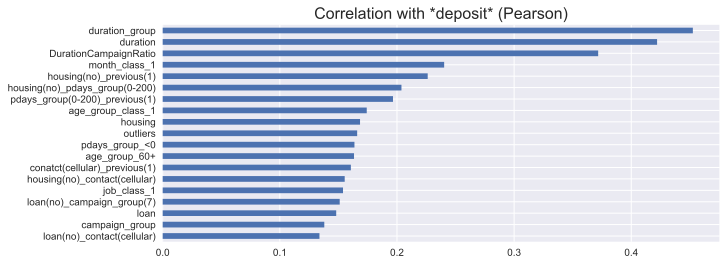

In [48]:
# визуализируем корреляцию Пирсона
data_corr.corr()["deposit"].apply(lambda x: abs(x)).sort_values()[-20:-1].plot.barh(figsize=(10, 4))
plt.title("Correlation with *deposit* (Pearson)", fontsize = 16)
plt.show()

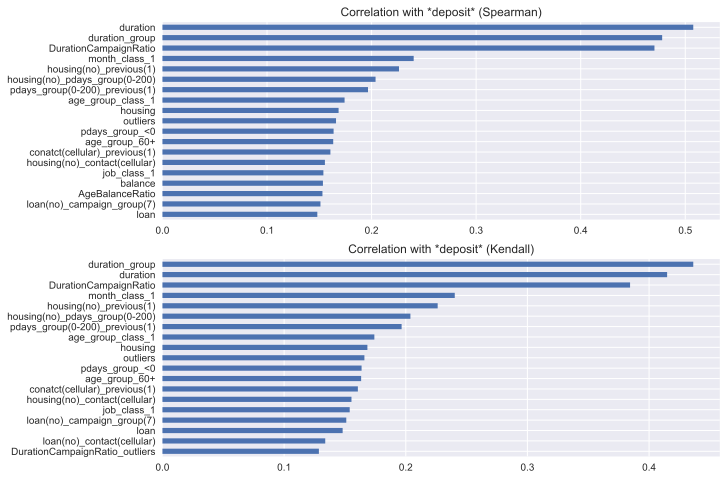

In [49]:
# визуализируем корреляции Спирмена и Кендалла
fig, ax =plt.subplots(2, 1)
data_corr.corr(method='spearman')["deposit"].apply(lambda x: abs(x)).sort_values()[-20:-1].plot.barh(figsize=(10, 8), ax=ax[0]).set_title(
    'Correlation with *deposit* (Spearman)');
data_corr.corr(method='kendall')["deposit"].apply(lambda x: abs(x)).sort_values()[-20:-1].plot.barh(figsize=(10, 8),ax=ax[1]).set_title(
    'Correlation with *deposit* (Kendall)');
fig.show();

**Выводы:**
- в тройке лидеров по корреляции с таргетом **duration**, **duration_group**, **DurationCampaignRatio**. Другими словами, продолжительность разговора (и производные этого признака) наиболее сильно влияет на таргет, что было сразу отмечено на прошлой итерации при анализе корреляций первичных числовых признаков.
- выбросы, помеченные методами библиотеки sklearn сильнее коррелируют с таргетом, чем найденные вручную методом Z-отклонений. Что и требовалось доказать.

### 5.3. Тест ANOVA

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит  анализ ANOVA. Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

In [50]:
# выделим непрерывные числовые и категориальные признаки 

df_num_features = [] # здесь будут непрерывные числовые признаки
df_cat_features = [] # здесь будут категориальные признаки
features = X_train_new.columns.to_list() # получаем список признаков

for feature in features:
    # если кол-во уникальных значений > 10 относим признак к непрерывным числовым
    if X_train_new[feature].nunique() > 10: 
        df_num_features.append(feature)
    # если кол-во уникальных значений < 10 относим признак к категориальным
    else:
        df_cat_features.append(feature)


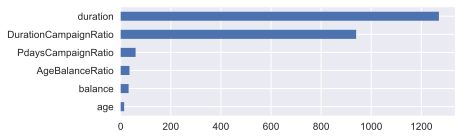

In [51]:
# проводим тест ANOVA 
imp_num = pd.Series(f_classif(X_train_new[df_num_features], y_train)[0], index = df_num_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(6, 2));

**Вывод:**
Признаки **duration** и **DurationCampaignRatio** в топе значимости.

### 5.4. Тест хи-квадрат

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

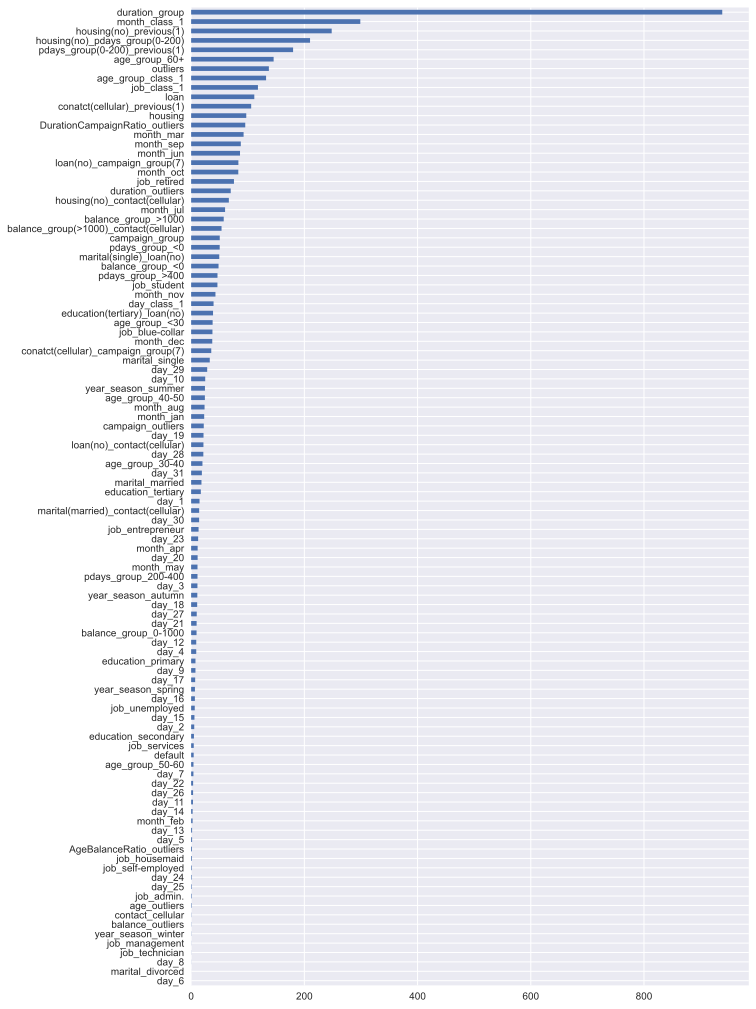

In [52]:
# проводим тест Xi-квадрат
imp_cat = pd.Series(chi2(X_train_new[df_cat_features], y_train)[0], index=df_cat_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(10, 18));

**Выводы:**
- примерно то же, что мы видели выше на коррелиции признаков с таргетом

### 5.5. Окончательный отбор признаков

In [53]:
# используем SelectKBest
selector = SelectKBest(
    f_classif, # вариант ANOVA показал себя лучше
    k=100 # все-таки чем больше признаков, тем лучше
)
selector.fit(X_train_new, y_train)
# создаем список отобранных признаков 
features_sel = selector.get_feature_names_out().tolist()

In [54]:
# обновляем выборки
X_train_new = X_train_new[features_sel]
X_test_new = X_test_new[features_sel]

## 5. Нормализуем данные

In [55]:
# нормализуем данные

scaler = preprocessing.RobustScaler()             # RobustScaler показал себя чуть лучше
scaler.fit(X_train_new)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train_new)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test_new)      # fransform() на test данных

***
***

## 6. Работа с моделями

Кодировать таргет необязательно, если мы просто работаем с моделями. Однако, тогда при подборе гиперпараметров нам вернется пустое значение с ошибкой. Закодируем таргет следующим образом:    
класс 0 = 'no' = 0;    
класс 1 = 'yes' = 1.

In [56]:
# кодируем трагет на тренировочной выборке
y_train = y_train.apply(
    lambda x: 1 if x == 'yes' else 0
)
# кодируем трагет на тестовой выборке
y_test = y_test.apply(
    lambda x: 1 if x == 'yes' else 0
)

---

### 6.1. Логистическая регрессия

In [57]:
# Создаём модель логистической регрессии
model_lr = linear_model.LogisticRegression(
    random_state = random_state
    )
 
# обучаем модель
model_lr.fit(X_train_scaled, y_train)

# делаем предсказание на тренировочной и тестовой выборке
y_train_pred = model_lr.predict(X_train_scaled)
y_test_pred = model_lr.predict(X_test_scaled)

# расчитываем и выводим метрику на тренировочной выборке
print('Train scores')
print(metrics.classification_report(y_train, y_train_pred))
print('-' * 60)
# расчитываем и выводим метрику на тестовой выборке
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Train scores
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2707
           1       0.83      0.84      0.83      3156

    accuracy                           0.82      5863
   macro avg       0.82      0.82      0.82      5863
weighted avg       0.82      0.82      0.82      5863

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1160
           1       0.84      0.84      0.84      1353

    accuracy                           0.82      2513
   macro avg       0.82      0.82      0.82      2513
weighted avg       0.82      0.82      0.82      2513



Неплохо. Можно ли улучшить целевую метрику?

Построим PR-кривую, вычислим лучший порог вероятности, *f1-score* и площадь под PR-кривой на **тренировочной** выборке.

Best threshold = 0.36, F1-Score = 0.84
PR AUC: 0.87


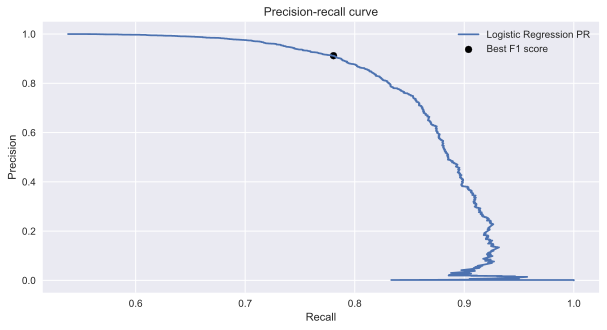

In [58]:
plot_pr_curve(model_lr, X_train_scaled, y_train, kf, 'Logistic Regression')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [59]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.36

# вычислим метрики с новым порогом
y_test_pred_proba = model_lr.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1160
           1       0.79      0.92      0.85      1353

    accuracy                           0.83      2513
   macro avg       0.84      0.82      0.82      2513
weighted avg       0.84      0.83      0.83      2513

PR AUC: 0.88


На тестовой выборке целевая метрика *f1-score* достигла 0.85, однако мы получили сильный дисбланс метрик *precision* и *recall*. Особенно удручает низкий *precision*. Площадь под PR-кривой = 0.88

Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

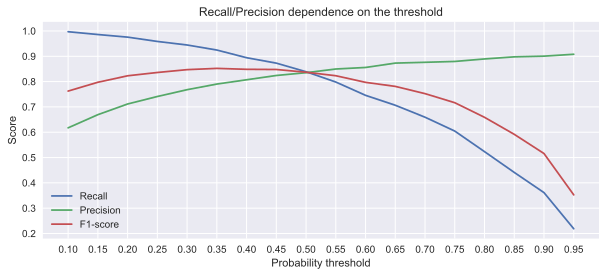

In [60]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(model_lr, X_test_scaled, y_test)

In [66]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.46
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1160
           1       0.83      0.87      0.85      1353

    accuracy                           0.83      2513
   macro avg       0.83      0.83      0.83      2513
weighted avg       0.83      0.83      0.83      2513

PR AUC: 0.88


При пороге вероятности = 0.46 мы сохранили целевую метрику *f1-score* = 0.85, подняли метрику *precision* = 0.83, уменьшив дисбаланс метрик *precision*/*recall* и сохранили площадь под PR-кривой = 0.88

Оценим модель, построив кривую обучения.

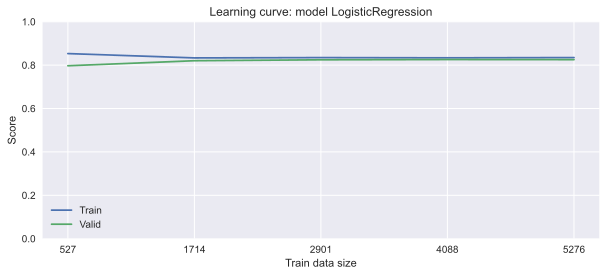

In [67]:
# строим кривую обучения модели LogisticRegression
plot_learning_curve(model_lr, X_train_scaled, y_train, kf, title=f'model LоgisticRegression')

**Выводы** по модели **логистической регрессии**:
- метрика улучшилась, по сравнению с предыдущими итерациями
- первоначально все метрики (кроме accuracy) на классах 0 (no) и 1(yes) сравнялись, достигнув 0.81 и 0.84 соотвественно
- интересно, что на тестовой выборке метрики чуть лучше, чем на тренировочной (это меня смущает, если честно)
- изменяя пороги вероятности мы достигли целевой метрики *f1-score* = 0.85, *precision*/*recall* = 0.83/0.87 и площадь под PR-кривой 0.88
- при построении кривой обучения обнаружено, что переобучения и недообучения нет; метрики стабилизировались после примерно 1800 наблюдений. Судя по всему, не смотря на потерю 25% датасета при удалении пропусков, оставшихся данных хватает для обучения модели.
- мы выжали из данной модели все, однако, я все же провел эксперимент с optuna (+ кросс-валидация) - улучшить показатели не удалось (они ухудшались).

---

### 6.2. Логистическая регрессия с полиномиальными признаками

Попробуем зайти с другой стороны - используем полиномиальные признаки.

In [68]:
# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

# Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)

# Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

# Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(5863, 5150)
(2513, 5150)


Количество признаков впечатляет...

In [69]:
# Создаём модель логистической регрессии
model_lr_poly = linear_model.LogisticRegression(
    solver='sag', # данный алгоритм чуть лучше по метрикам
    max_iter=1000, 
    random_state = random_state
    )
 
# обучаем модель
model_lr_poly.fit(X_train_poly, y_train)

# делаем предсказание на тренировочной и тестовой выборке
y_train_pred = model_lr_poly.predict(X_train_poly)
y_test_pred = model_lr_poly.predict(X_test_poly)

# расчитываем и выводим метрику на тренировочной выборке
print('Train scores')
print(metrics.classification_report(y_train, y_train_pred))
print('-' * 60)
# расчитываем и выводим метрику на тестовой выборке
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Train scores
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2707
           1       0.82      0.84      0.83      3156

    accuracy                           0.82      5863
   macro avg       0.82      0.81      0.81      5863
weighted avg       0.82      0.82      0.82      5863

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1160
           1       0.83      0.84      0.84      1353

    accuracy                           0.82      2513
   macro avg       0.82      0.82      0.82      2513
weighted avg       0.82      0.82      0.82      2513



Метрики немного ухудшились.

Best threshold = 0.36, F1-Score = 0.84
PR AUC: 0.87


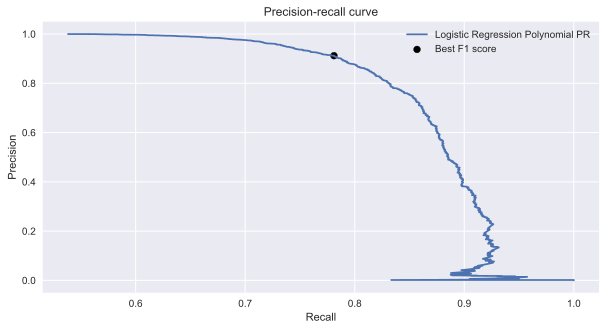

In [70]:
plot_pr_curve(model_lr_poly, X_train_scaled, y_train, kf, 'Logistic Regression Polynomial')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [71]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.36

# вычислим метрики с новым порогом
y_test_pred_proba = model_lr_poly.predict_proba(X_test_poly)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.90      0.65      0.76      1160
           1       0.76      0.94      0.84      1353

    accuracy                           0.81      2513
   macro avg       0.83      0.80      0.80      2513
weighted avg       0.82      0.81      0.80      2513

PR AUC: 0.87


Хороший *f1-score*, замечательный *recall*, но *precision* - никуда не годится!

Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

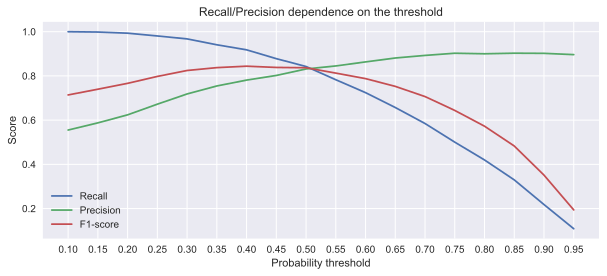

In [72]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(model_lr_poly, X_test_poly, y_test)

In [73]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.49
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1160
           1       0.83      0.85      0.84      1353

    accuracy                           0.82      2513
   macro avg       0.82      0.82      0.82      2513
weighted avg       0.82      0.82      0.82      2513

PR AUC: 0.88


Интересно, что на пороге вероятности 0.49 мы выжали из модели *f1-score* = 0.84, *precision*/*recall* = 0.83/0.85, площадь под PR-кривой 0.88

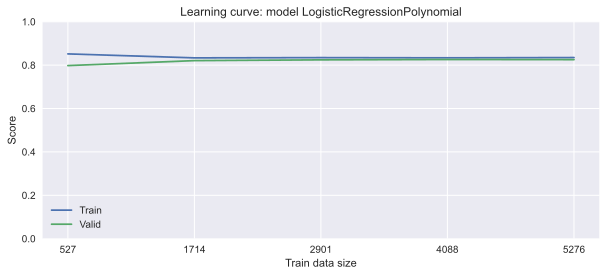

In [74]:
# строим кривую обучения модели LogisticRegression
plot_learning_curve(model_lr_poly, X_train_scaled, y_train, kf, title=f'model LоgisticRegressionPolynomial')

Кривая обучения похожа на кривую предыдущей модели.

**Выводы** по модели **логистической регрессии(с полиномиальными признаками)**:
- метрика стали хуже, по сравнению с моделью обычной логистической регресии
- модель очень ресурсозатратна, для настройки и подбора гиперпараметров требуются серьезные вычислительные мощности и результат неочевиден

---

### 6.3. Дерево решений с оптимизацией Optuna + кросс-валидация

In [75]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', low=2, high=10, step=1, log=False)
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=10, step=1, log=False)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=2, high=10, step=1, log=False)
    

    # создаем модель
    model_dt_optuna = tree.DecisionTreeClassifier( 
          random_state=random_state,
          #class_weight='balanced',
        
          criterion=criterion,
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf
          
    )
    
    # обучаем модель
    model_dt_optuna.fit(X_train_scaled, y_train)
    
    # метрика без кросс-валидации
    #score = metrics.f1_score(y_train, model.predict(X_train))

    # метрика с кросс-валидацией
    score = cross_val_score(model_dt_optuna, X_train_scaled, y_train, cv=kf, scoring="f1", n_jobs=-1).mean()

    return score

In [76]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="DecisionTreeClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=1000)

[I 2023-02-01 16:16:54,724] A new study created in memory with name: DecisionTreeClassifier
[I 2023-02-01 16:16:57,186] Trial 0 finished with value: 0.8082716245867131 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8082716245867131.
[I 2023-02-01 16:16:57,304] Trial 1 finished with value: 0.8126969212707937 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8126969212707937.
[I 2023-02-01 16:16:57,373] Trial 2 finished with value: 0.7564464998501775 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8126969212707937.
[I 2023-02-01 16:16:57,489] Trial 3 finished with value: 0.7978282362018327 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.812696921270

CPU times: user 46.9 s, sys: 3.92 s, total: 50.8 s
Wall time: 1min 56s


In [77]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 8}
f1_score на обучающем наборе: 0.82


In [78]:
# создаем модель с подобранными гиперпараметрами
model_dt_optuna = tree.DecisionTreeClassifier( 
        **study.best_params,                                
        random_state=random_state
)
# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model_dt_optuna, # модель
    X=X_train_scaled, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
# выводим метрики
print('Train k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


Train k-fold mean f1_score: 0.84
Valid k-fold mean f1_score: 0.82


In [79]:
# обучаем модель
model_dt_optuna.fit(X_train_scaled, y_train)

# делаем предсказание на тестовой выборке
y_test_pred = model_dt_optuna.predict(X_test_scaled)

# расчитываем и выводим метрику на тестовой выборке
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Test scores
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1160
           1       0.83      0.80      0.82      1353

    accuracy                           0.81      2513
   macro avg       0.80      0.81      0.80      2513
weighted avg       0.81      0.81      0.81      2513



На примере дерева решений определим важность признаков

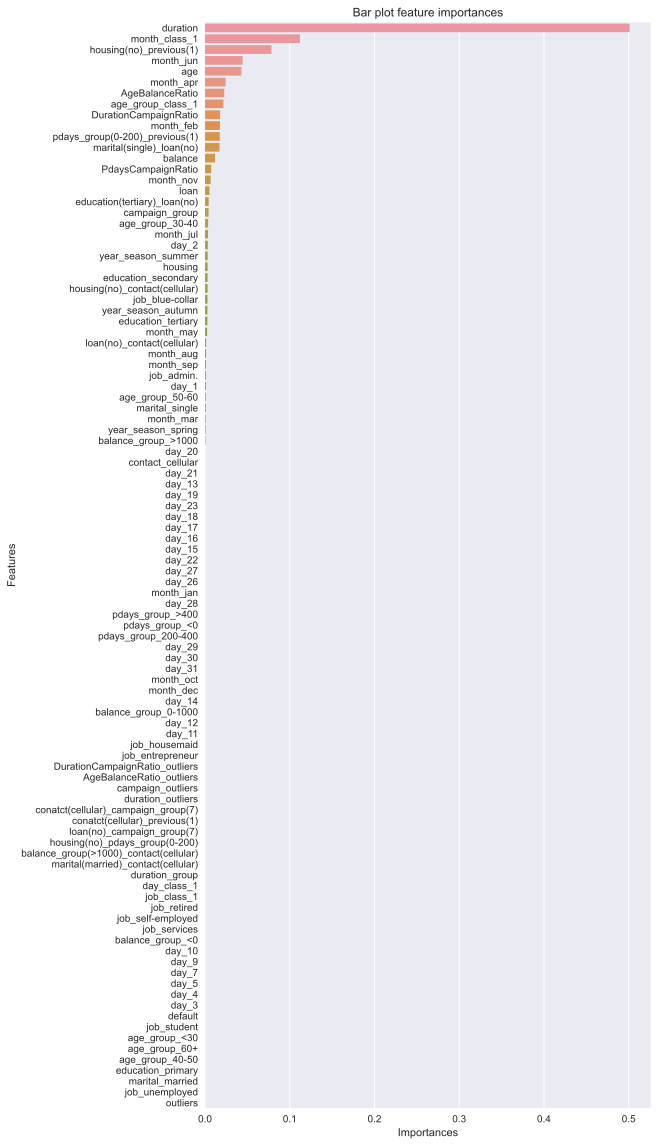

In [80]:
fig, ax = plt.subplots(figsize=(8, 20)) # фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = model_dt_optuna.feature_importances_ # важность признаков
# создаем объект Series, чтобы отсортировать по важности признаки
feature_importances_series = pd.Series(
    data=feature_importances,
    index=feature
).sort_values(ascending=False)
# Строим столбчатую диаграмму
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, ax=ax);
# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Importances')
ax.set_ylabel('Features');

Построим PR-кривую, вычислим лучший порог вероятности, *f1-score* и площадь под PR-кривой на **тренировочной** выборке.

Best threshold = 0.30, F1-Score = 0.82
PR AUC: 0.85


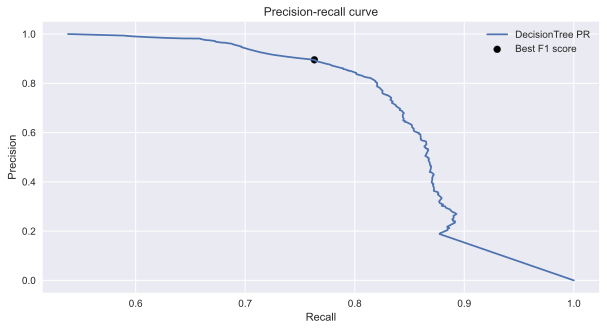

In [81]:
plot_pr_curve(model_dt_optuna, X_train_scaled, y_train, kf, 'DecisionTree')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [82]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.30

# вычислим метрики с новым порогом
y_test_pred_proba = model_dt_optuna.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1160
           1       0.76      0.90      0.83      1353

    accuracy                           0.80      2513
   macro avg       0.81      0.79      0.79      2513
weighted avg       0.81      0.80      0.79      2513

PR AUC: 0.86


На тестовой выборке целевая метрика *f1-score* достигла 0.83, однако мы получили сильный дисбланс метрик *precision* и *recall*. Особенно удручает низкий *precision*. Площадь под PR-кривой = 0.86

Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

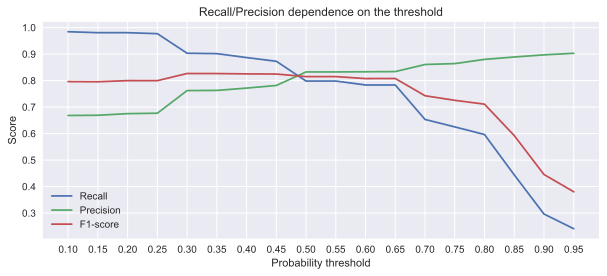

In [83]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(model_dt_optuna, X_test_scaled, y_test)

In [84]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.48
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1160
           1       0.82      0.82      0.82      1353

    accuracy                           0.81      2513
   macro avg       0.81      0.81      0.81      2513
weighted avg       0.81      0.81      0.81      2513

PR AUC: 0.87


При пороге вероятности = 0.48 мы получили *f1-score* = *precision* = 0.82, площадь под PR-кривой увеличилась до 0.87

Оценим модель, построив кривую обучения.

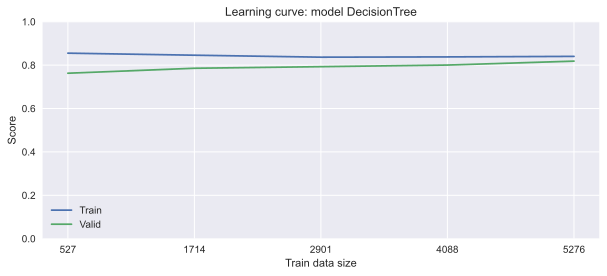

In [85]:
# строим кривую обучения модели DecisionTree
plot_learning_curve(model_dt_optuna, X_train_scaled, y_train, kf, title=f'model DecisionTree')

**Выводы** по модели **дерево решений**:
- мы избавились от переобучения
- данная модель по метрикам показывает себя хуже логистической регрессии
- задав порог вероятности 0.48 мы уравниваем метрики *f1-score* = *precision* = *recall* = 0.82, площадь под PR-кривой = 0.87
- самый важный признак для модели - **duration**, остальные в топе - категориальные признаки
- также в топе есть признаки, которые мы создавали на прошлой итерации
- по кривой обучения также отмечается отсутствие переобучения, но не уверен, что метрики стабилизировались

---

### 6.4. Случайный лес с оптимизацией Optuna + кросс-валидация

In [86]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', low=50, high=500, step=10, log=False)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', low=2, high=5, step=1, log=False)
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=20, step=1, log=False)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=2, high=20, step=1, log=False)
    

    # создаем модель
    model_rf_optuna = ensemble.RandomForestClassifier( 
          random_state=random_state,
      
          n_estimators=n_estimators,  
          criterion=criterion,
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf
          
    )
    
    # обучаем модель
    model_rf_optuna.fit(X_train_scaled, y_train)
    
    # метрика без кросс-валидации
    #score = metrics.f1_score(y_train, model.predict(X_train))

    # метрика с кросс-валидацией
    score = cross_val_score(model_rf_optuna, X_train_scaled, y_train, cv=kf, scoring="f1", n_jobs=-1).mean()

    return score

In [87]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=150)

[I 2023-02-01 16:21:25,686] A new study created in memory with name: RandomForestClassifier
[I 2023-02-01 16:21:27,148] Trial 0 finished with value: 0.815731965688571 and parameters: {'n_estimators': 340, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.815731965688571.
[I 2023-02-01 16:21:28,372] Trial 1 finished with value: 0.8151732741462716 and parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.815731965688571.
[I 2023-02-01 16:21:28,741] Trial 2 finished with value: 0.8282414562697535 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8282414562697535.
[I 2023-02-01 16:21:30,140] Trial 3 finished with value: 0.8283272094474601 and parameters: {'n_estimators': 270, 'criterion': 'gini', 'max_depth': 5, 'min_samples_sp

CPU times: user 1min 45s, sys: 1.89 s, total: 1min 47s
Wall time: 4min 18s


In [88]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 320, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 12}
f1_score на обучающем наборе: 0.83


In [89]:
# создаем модель с подобранными гиперпараметрами
model_rf_optuna = ensemble.RandomForestClassifier( 
        **study.best_params,                                
        random_state=random_state
)
# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model_rf_optuna, # модель
    X=X_train_scaled, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
# выводим метрики
print('Train k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


Train k-fold mean f1_score: 0.84
Valid k-fold mean f1_score: 0.83


In [90]:
# обучаем модель
model_rf_optuna.fit(X_train_scaled, y_train)

# делаем предсказание на тестовой выборке
y_test_pred = model_rf_optuna.predict(X_test_scaled)

# расчитываем и выводим метрику на тестовой выборке
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Test scores
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1160
           1       0.80      0.88      0.83      1353

    accuracy                           0.81      2513
   macro avg       0.82      0.81      0.81      2513
weighted avg       0.82      0.81      0.81      2513



На примере случайного леса определим важность признаков

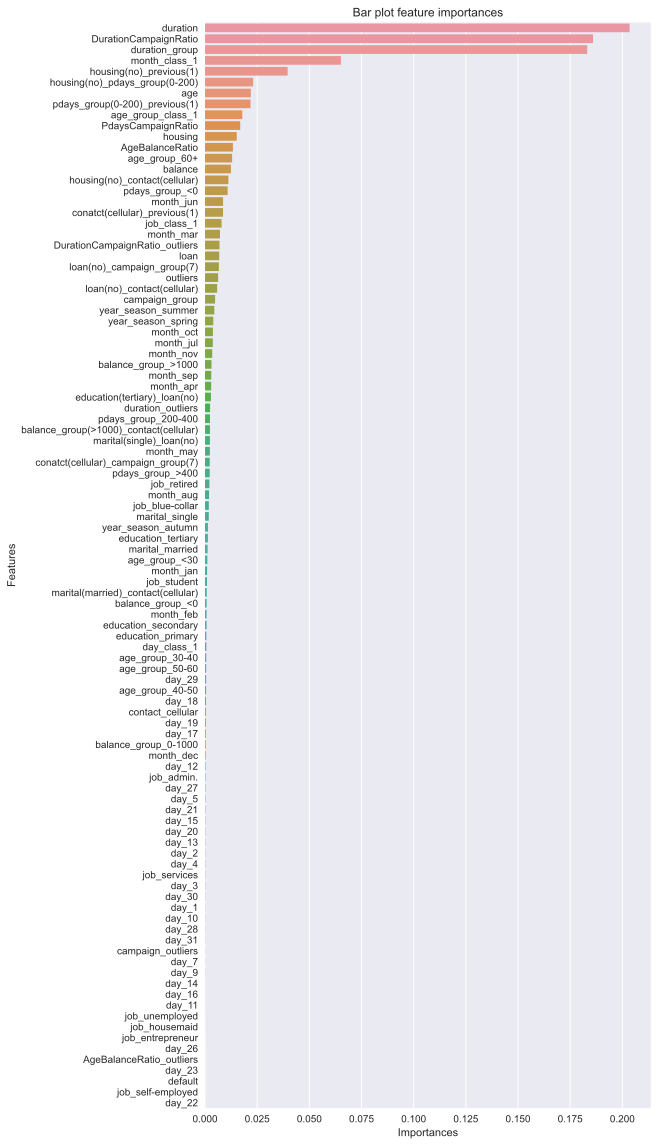

In [91]:
fig, ax = plt.subplots(figsize=(8, 20)) # фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = model_rf_optuna.feature_importances_ # важность признаков
# создаем объект Series, чтобы отсортировать по важности признаки
feature_importances_series = pd.Series(
    data=feature_importances,
    index=feature
).sort_values(ascending=False)
# Строим столбчатую диаграмму
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, ax=ax);
# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Importances')
ax.set_ylabel('Features');

Построим PR-кривую, вычислим лучший порог вероятности, *f1-score* и площадь под PR-кривой на **тренировочной** выборке.

Best threshold = 0.49, F1-Score = 0.83
PR AUC: 0.86


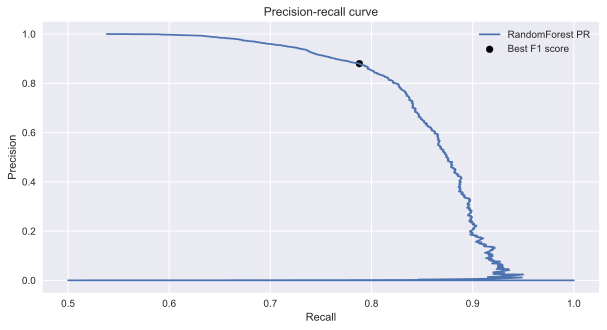

In [92]:
plot_pr_curve(model_rf_optuna, X_train_scaled, y_train, kf, 'RandomForest')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [93]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.49

# вычислим метрики с новым порогом
y_test_pred_proba = model_rf_optuna.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1160
           1       0.79      0.88      0.83      1353

    accuracy                           0.81      2513
   macro avg       0.81      0.80      0.81      2513
weighted avg       0.81      0.81      0.81      2513

PR AUC: 0.87


Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

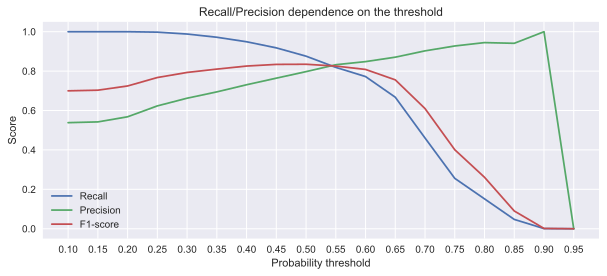

In [94]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(model_rf_optuna, X_test_scaled, y_test)

In [95]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.54
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1160
           1       0.83      0.83      0.83      1353

    accuracy                           0.82      2513
   macro avg       0.82      0.82      0.82      2513
weighted avg       0.82      0.82      0.82      2513

PR AUC: 0.88


Задав порог вероятности = 0.54 мы сравняли метрики *precision* = *f1-score* = 0.83, площадь по PR-кривой = 0.88

Оценим модель, построив кривую обучения.

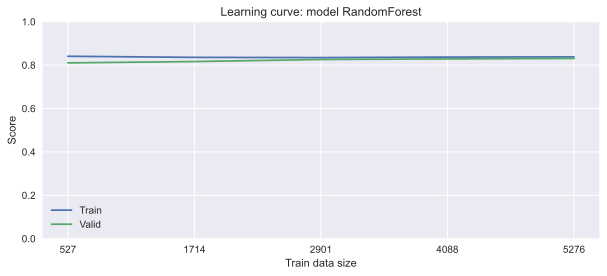

In [96]:
# строим кривую обучения модели Random Forest
plot_learning_curve(model_rf_optuna, X_train_scaled, y_train, kf, title=f'model RandomForest')

**Выводы** по модели **случайного леса**:
- мы избавились от переобучения
- в топе важных признаков - **duration** и его производные
- изменив порог вероятности на 0.54 мы сравняли метрики *precision* = *f1-score* = 0.83, площадь под PR-кривой = 0.88
- кривая обучения также демонстрирует отсутствие переобучения, метрики стабилизировались после 2900 наблюдений
- модель показывает явно более хорошие результаты, чем дерево решений

---

### 6.5. Градиентный бустинг с оптимизацией Optuna + кросс-валидация

In [97]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    #n_estimators = trial.suggest_int('n_estimators', low=50, high=500, step=10, log=False)
    #max_depth = trial.suggest_int('max_depth', low=3, high=4, step=1, log=False)
    min_samples_split = trial.suggest_int('min_samples_split', low=7, high=10, step=1, log=False)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=7, high=10, step=1, log=False)
    learning_rate = trial.suggest_float('learning_rate', low=0.01, high=0.3, step=0.01)
    
    # создаем модель
    model_gb_optuna = ensemble.GradientBoostingClassifier( 
          random_state=random_state,
      
          n_estimators=500,  
          max_depth=5,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf,
          learning_rate=learning_rate
    )
    
    # обучаем модель
    model_gb_optuna.fit(X_train_scaled, y_train)
    
    # метрика без кросс-валидации
    #score = metrics.f1_score(y_train, model.predict(X_train))

    # метрика с кросс-валидацией
    score = cross_val_score(model_gb_optuna, X_train_scaled, y_train, cv=kf, scoring="f1", n_jobs=-1).mean()

    return score

In [98]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

[I 2023-02-01 16:31:59,018] A new study created in memory with name: GradientBoostingClassifier
[I 2023-02-01 16:32:21,703] Trial 0 finished with value: 0.8517949419585864 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 10, 'learning_rate': 0.02}. Best is trial 0 with value: 0.8517949419585864.
[I 2023-02-01 16:32:42,442] Trial 1 finished with value: 0.8520378113903068 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 8, 'learning_rate': 0.08}. Best is trial 1 with value: 0.8520378113903068.
[I 2023-02-01 16:33:03,309] Trial 2 finished with value: 0.8508448300953868 and parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'learning_rate': 0.04}. Best is trial 1 with value: 0.8520378113903068.
[I 2023-02-01 16:33:23,960] Trial 3 finished with value: 0.8456193426592854 and parameters: {'min_samples_split': 10, 'min_samples_leaf': 9, 'learning_rate': 0.3}. Best is trial 1 with value: 0.8520378113903068.
[I 2023-02-01 16:33:44,715] Trial 4 finished with val

CPU times: user 16min 3s, sys: 6.19 s, total: 16min 10s
Wall time: 35min 1s


In [99]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_split': 7, 'min_samples_leaf': 8, 'learning_rate': 0.02}
f1_score на обучающем наборе: 0.85


In [100]:
# создаем модель с подобранными гиперпараметрами
model_gb_optuna = ensemble.GradientBoostingClassifier( 
        **study.best_params,                                
        random_state=random_state,
        n_estimators=500,
        max_depth=5
)
# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model_gb_optuna, # модель
    X=X_train_scaled, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
# выводим метрики
print('Train k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1_score: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


Train k-fold mean f1_score: 0.90
Valid k-fold mean f1_score: 0.85


In [101]:
# обучаем модель
model_gb_optuna.fit(X_train_scaled, y_train)

# делаем предсказание на тестовой выборке
y_test_pred = model_gb_optuna.predict(X_test_scaled)

# расчитываем и выводим метрику на тестовой выборке
print('Test scores')
print(metrics.classification_report(y_test, y_test_pred))

Test scores
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1160
           1       0.83      0.88      0.86      1353

    accuracy                           0.84      2513
   macro avg       0.84      0.84      0.84      2513
weighted avg       0.84      0.84      0.84      2513



Неплохо! 

На примере градиентного бустинга определим важность признаков

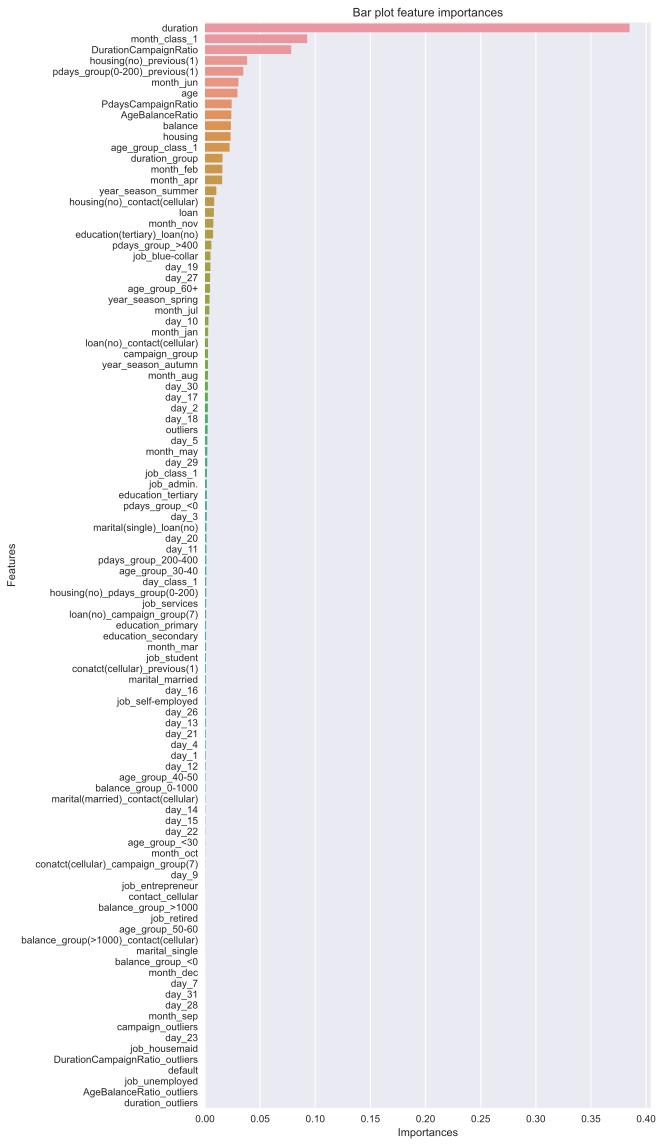

In [102]:
fig, ax = plt.subplots(figsize=(8, 20)) # фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = model_gb_optuna.feature_importances_ # важность признаков
# создаем объект Series, чтобы отсортировать по важности признаки
feature_importances_series = pd.Series(
    data=feature_importances,
    index=feature
).sort_values(ascending=False)
# Строим столбчатую диаграмму
sns.barplot(x=feature_importances_series, y=feature_importances_series.index, ax=ax);
# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Importances')
ax.set_ylabel('Features');

Строим PR-кривую

Best threshold = 0.99, F1-Score = nan
PR AUC: 0.89


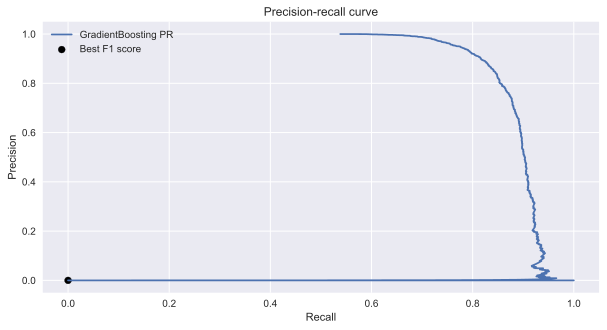

In [103]:
plot_pr_curve(model_gb_optuna, X_train_scaled, y_train, kf, 'GradientBoosting')

На ансамблях у меня часто PR-кривая строится с возвратом F1-score = nan, как сейчас. В чем причина - пока не разобрался.

Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

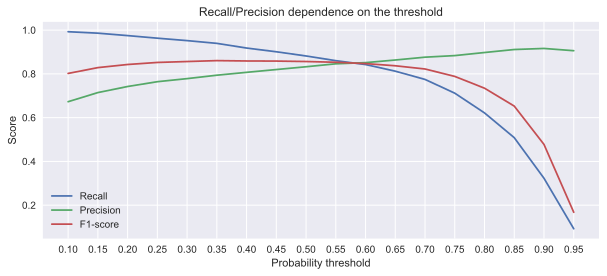

In [104]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(model_gb_optuna, X_test_scaled, y_test)

In [107]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.57
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1160
           1       0.85      0.86      0.85      1353

    accuracy                           0.84      2513
   macro avg       0.84      0.84      0.84      2513
weighted avg       0.84      0.84      0.84      2513

PR AUC: 0.89


При пороге вероятности = 0.57 *f1-score* = *precision* = 0.85 и площадь под PR-кривой = 0.89

Оценим модель, построив кривую обучения.

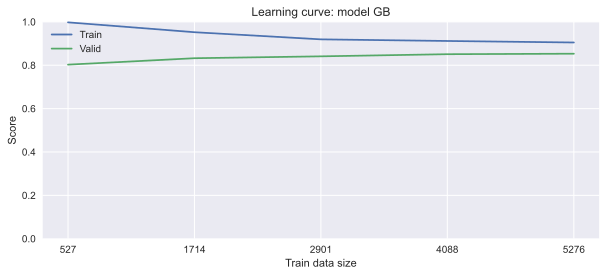

In [108]:
# строим кривую обучения модели Gradient Boosting
plot_learning_curve(model_gb_optuna, X_train_scaled, y_train, kf, title=f'model GB')

**Выводы** по модели **градиентного бустинга**:
- первоначальные метрики на тестовой выборке улучшились, мы достигли целевой метрики = 0.86
- задав порог вероятности = 0.57 мы получили *f1-score* = *precision* = 0.85 и получили площадь под PR-кривой = 0.89
- по кривой обучения можно отметить стабилизацию метрик после 4000 наблюдений, отмечается бОльший разброс, по сравнению с моделями выше

---

### 6.6. Стекинг

#### 6.6.1 Стекинг на слабых моделях (параметры по умолчанию, добавлен class_weight)

In [109]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', linear_model.LogisticRegression(
        random_state = random_state,
        class_weight = 'balanced'
    )),
    ('dt',  tree.DecisionTreeClassifier(
        random_state = random_state,
        class_weight = 'balanced'
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        random_state = random_state
    )),
    ('rf', ensemble.RandomForestClassifier(
        random_state = random_state,
        class_weight = 'balanced'
    )),
]

# Создаем объект класса стекинг
stacking_cl = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.GradientBoostingClassifier(
        random_state = random_state
    )
)

# Обучаем модель
stacking_cl.fit(X_train_scaled, y_train)

# Делаем предсказание класса
y_pred_train = stacking_cl.predict(X_train_scaled)
y_pred_test = stacking_cl.predict(X_test_scaled)

# Выводим отчет о метриках
print('Train scores')
print(metrics.classification_report(y_train, y_pred_train))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_pred_test))

Train scores
              precision    recall  f1-score   support

           0       0.95      0.87      0.90      2707
           1       0.89      0.96      0.92      3156

    accuracy                           0.92      5863
   macro avg       0.92      0.91      0.91      5863
weighted avg       0.92      0.92      0.92      5863

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1160
           1       0.82      0.89      0.85      1353

    accuracy                           0.83      2513
   macro avg       0.84      0.83      0.83      2513
weighted avg       0.84      0.83      0.83      2513



Тоже неплохо!

Строим PR-кривую

Best threshold = 0.44, F1-Score = 0.85
PR AUC: 0.87


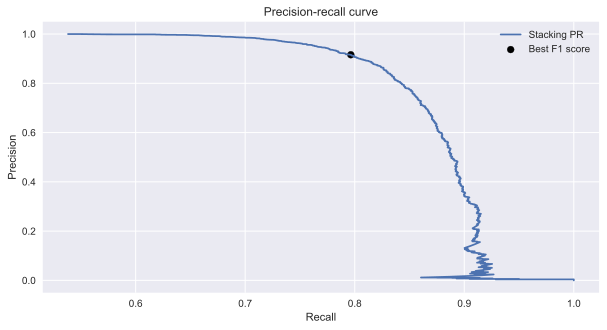

In [110]:
plot_pr_curve(stacking_cl, X_train_scaled, y_train, kf, 'Stacking')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [111]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.44

# вычислим метрики с новым порогом
y_test_pred_proba = stacking_cl.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1160
           1       0.80      0.92      0.85      1353

    accuracy                           0.83      2513
   macro avg       0.84      0.82      0.83      2513
weighted avg       0.84      0.83      0.83      2513

PR AUC: 0.88


Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

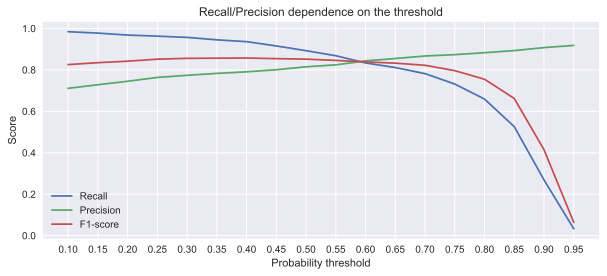

In [112]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(stacking_cl, X_test_scaled, y_test)

In [113]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.60
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1160
           1       0.84      0.83      0.84      1353

    accuracy                           0.83      2513
   macro avg       0.83      0.83      0.83      2513
weighted avg       0.83      0.83      0.83      2513

PR AUC: 0.88


При пороге вероятности = 0.60, *f1-score* = *precision* = 0.84 и площадь под PR-кривой = 0.88

Оценим модель, построив кривую обучения.

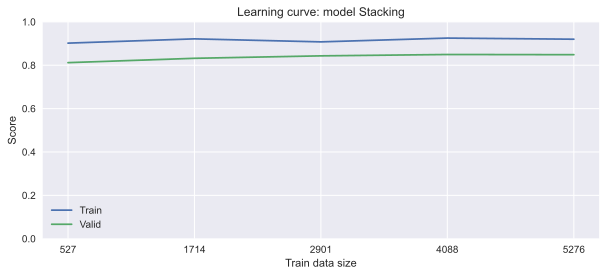

In [114]:
# строим кривую обучения модели Stacking
plot_learning_curve(stacking_cl, X_train_scaled, y_train, kf, title=f'model Stacking')

**Выводы** по модели **стекинга**:
- на первичных метриках мы достигли *f1-score* = 0.85
- задав порог вероятности = 0.60 мы получили *f1-score* = *precision* = 0.84 и площадь под PR-кривой = 0.88
- переобучения нет, так же бОльший разброс, по сравнению с моделями логистической регрессии, дерева решений и случайного леса

---

#### 6.6.2 Попробуем завернуть в стекинг все наши модели, обученные выше (создадим модель стекинга 2-й версии).

In [115]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', model_lr),
    ('log_reg_poly', model_lr_poly),
    ('dt',  model_dt_optuna),
    ('gb', model_gb_optuna),
    ('rf', model_rf_optuna),
    ('stacking', stacking_cl)
]

# Создаем объект класса стекинг
stacking_cl_v2 = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        random_state = random_state
    )
)

# Обучаем модель
stacking_cl_v2.fit(X_train_scaled, y_train)

# Делаем предсказание класса
y_pred_train = stacking_cl_v2.predict(X_train_scaled)
y_pred_test = stacking_cl_v2.predict(X_test_scaled)

# Выводим отчет о метриках
print('Train scores')
print(metrics.classification_report(y_train, y_pred_train))
print('-' * 60)
print('Test scores')
print(metrics.classification_report(y_test, y_pred_test))

Train scores
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2707
           1       0.88      0.93      0.91      3156

    accuracy                           0.90      5863
   macro avg       0.90      0.89      0.90      5863
weighted avg       0.90      0.90      0.90      5863

------------------------------------------------------------
Test scores
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1160
           1       0.83      0.88      0.86      1353

    accuracy                           0.84      2513
   macro avg       0.84      0.84      0.84      2513
weighted avg       0.84      0.84      0.84      2513



Эти метрики мне нраятся больше, особенно *f1-score* = 0.86!

Строим PR-кривую

Best threshold = 0.36, F1-Score = 0.86
PR AUC: 0.89


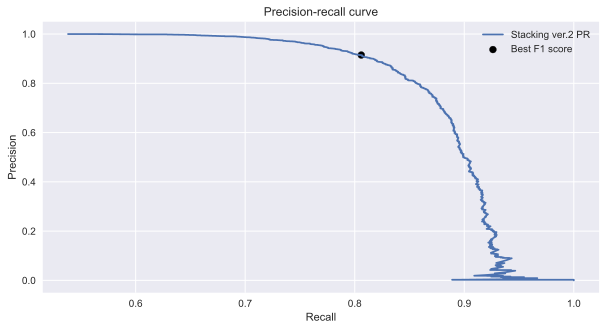

In [116]:
plot_pr_curve(stacking_cl_v2, X_train_scaled, y_train, kf, 'Stacking ver.2')

Расчитаем метрики на **тестовой** выборке, изменив порог вероятности на оптимальный.

In [117]:

# указываем расчитанный оптимальный порог вероятности
threshold_opt = 0.36

# вычислим метрики с новым порогом
y_test_pred_proba = stacking_cl_v2.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1160
           1       0.81      0.92      0.86      1353

    accuracy                           0.84      2513
   macro avg       0.85      0.83      0.83      2513
weighted avg       0.84      0.84      0.84      2513

PR AUC: 0.88


Построим график зависимости метрик от порога вероятности на **тестовой** выборке.

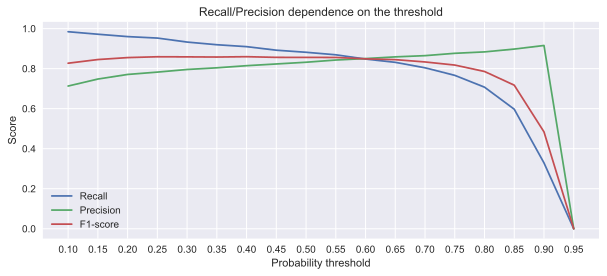

In [118]:
# строим график и получаем вектор вероятностей принадлежности классу 1
y_test_proba_pred = dependence_metrics_threshold(stacking_cl_v2, X_test_scaled, y_test)

In [119]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.60
#Делаем предсказание
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_opt)
# вычисляем площадь под PR-кривой
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1160
           1       0.85      0.85      0.85      1353

    accuracy                           0.84      2513
   macro avg       0.84      0.84      0.84      2513
weighted avg       0.84      0.84      0.84      2513

PR AUC: 0.89


При пороге вероятности = 0.60 все метрики = 0.85 (кроме *accuracy*) и площадь под PR-кривой = 0.89

Оценим модель, построив кривую обучения.    
Кривая строится у меня по времени почти час, поэтому просто озвучу вывод - не сильно отличается от предыдущей модели стекинга.

**Выводы** по модели **стекинга версии 2**:
- на первичных метриках мы достигли *f1-score* = 0.86
- задав порог вероятности = 0.60 мы сравняли все метрики до 0.85 (кроме *accuracy*), площадь под PR-кривой = 0.89
- переобучения нет, но так же бОльший разброс, по сравнению с моделями логистической регрессии, дерева решений и случайного леса

***
***

## 7. Итоги и выводы по моделям

**Примечание:** при перезапуске ноутбука значения некоторых метрик у некоторых моделей могут менятся +/- на 0.01

#### 7.1. Логистическая регрессия (model_lr)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.36</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.79</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.92</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.46</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- простая, быстрая, ресурсонезатратная
- настройка гиперепараметров не улучшает метрику (можно обойтись без нее)
- отличная кривая обучения (на мой взгляд, лучшая среди моделей)    

Недостатки модели:
- не самые лучшие результаты метрик

#### 7.2. Логистическая регрессия с полиномиальными признаками (model_lr_poly)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.36</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.76</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.94</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.49</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- нет

Недостатки модели:
- по метрикам несколько хуже обычной логистической регрессии
- очень ресурсозатратна !

#### 7.3. Дерево решений + Optuna + CV (model_dt_optuna)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.80</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.30</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.76</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.90</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.80</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.48</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- не требует большие ресурсы при обучении и настройке гиперпараметров
- можно увидеть какие признаки важны для обучения модели

Недостатки модели:
- слабые метрики и PR AUC
- нет уверенности, что на кривой обучения метрики стабилизировались

#### 7.4. Случайный лес + Optuna + CV (model_rf_optuna)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.80</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.49</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.79</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.87</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.54</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- требует меньшие ресурсы при обучении и настройке гиперпараметров, по сравнению с другими ансамблями
- неплохой PR AUC
- можно увидеть какие признаки важны для обучения модели
- лично мне понравилась кривая обучения

Недостатки модели:
- слабые метрики

#### 7.4.5. Градиентный бустинг + Optuna + CV (model_gb_optuna)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.57</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
  </tr>
  <tr>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- хорошие метрики и PR AUC
- можно увидеть какие признаки важны для обучения модели

Недостатки модели:
- очень ресурсозатратна при подборе гиперпараметров
- есть разброс на кривой обучения, по сравнению с моделями логистической регрессии, дерева решений и случайного леса

#### 7.4.6. Стекинг на слабых моделях (stacking_cl)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.82</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.44</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.80</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.92</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.60</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- хорошие метрики и PR AUC

Недостатки модели:
- метрики чуть хуже, чем у градиентного бустинга
- модель ресурсозатратна, подбор гиперпараметров только на облачных ресурсах
- есть разброс на кривой обучения, по сравнению с моделями логистической регрессии, дерева решений и случайного леса

#### 7.4.7. Стекинг на всех обученных нами моделях (stacking_cl_v2) 

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ihq5{background-color:#B0B3B2;color:#FB0207;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-9kw6{background-color:#B0B3B2;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-h2pf{background-color:#D4D4D4;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-8mdw{background-color:#B0B3B2;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rfng{background-color:#D4D4D4;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-8mdw">Выборка</th>
    <th class="tg-9kw6" colspan="4">Test</th>
    <th class="tg-9kw6" rowspan="2">PR AUC</th>
  </tr>
  <tr>
    <th class="tg-8mdw">Метрики</th>
    <th class="tg-9kw6">Precision</th>
    <th class="tg-9kw6">Recall</th>
    <th class="tg-ihq5">F1-score</th>
    <th class="tg-9kw6">Accuracy</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-rfng"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold (по умолчанию)</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.83</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.36</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.81</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.92</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.86</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.88</span></td>
  </tr>
  <tr>
    <td class="tg-h2pf">Threshold = 0.60</td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.85</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.84</span></td>
    <td class="tg-baqh"><span style="font-weight:normal;font-style:normal;color:#000">0.89</span></td>
  </tr>
</tbody>
</table>

Достоинства модели:
- самые лучшие метрики и PR AUC

Недостатки модели:
- модель ресурсозатратна, подбор гиперпараметров только на облачных ресурсах

## 8. Итоги и выводы по итерации

- были заново обработаны непрерывные числовые признаки, найдены выбросы методом Z-отклонений
- были найдены выбросы в тренировочной и тестовой выборках алгоритмами sklearn, выбран лучший - Isolation Forest
- были обнаружены и удалены мультиколлинеарные признаки
- найдены факторы наиболее сильно влияющие на таргет (корреляции, тесты ANOVA и Xi-квадрат)
- был произведен отбор признаков для моделей
- был подобран метод нормализации - RobustScaler
- было выбрано и обучено 7 моделей для решения задачи классификации
- в моделях на основе деревьев решений отмечены важные признаки для обучения
- было подтверждена важность проведенного EDA+FE для обучения моделей и улучшения метрики
- тестовая часть была отделена от тренировочной выборки и использовалась только для оценки качества моделей и регулирования порога вероятности
- там где это было возможно, строилась PR-кривая на обучающей выборке, изменялся порог верятности на тестовой выборке, использовалась оптимизация Optuna с кросс-валидацией, строились кривые обучения
- были сведены результаты метрик и PR AUC моделей, сделаны выводы по моделям
- к сожалению, метрики моделей иногда 'гуляют' +/-0.01 (вероятно, связано с работой Isolation Forest)
- не всегда нормально строится PR-кривая для ансамблевых моделей, иногда возвращает *F1-score* = nan
---
- созданные модели логистической регрессии с полиномиальными признаками и дерева решений следует признать неудовлетворительными
- остальные модели требуют испытаний на новых данных
- есть возможность улучшить гиперпараметры ансамблевых моделей (прежде всего стекинга) с использованием платных облачных ресурсов (Google Colab, Saturn Cloud, Yandex DataSphere). 

---

- я пробовал улучшить результаты моделей на основе деревьев решений (собственно, дерево решений, случайный лес, градиентный бустинг) путем удаления непрерывных числовых признаков и оставив только категориальные признаки, что теоретически должно было их улучшить (по крайней мере, хотя бы простое дерево решений), однако существенных успехов по метрикам не добился, но уменьшилось время их обучения и подбор гиперпараметров